Pdb;Mutation(s)_PDB;Mutation(s)_cleaned;iMutation_Location(s);Hold_out_type;Hold_out_proteins;Affinity_mut (M);Affinity_mut_parsed;Affinity_wt (M);Affinity_wt_parsed;Reference;Protein 1;Protein 2;Temperature;kon_mut (M^(-1)s^(-1));kon_mut_parsed;kon_wt (M^(-1)s^(-1));kon_wt_parsed;koff_mut (s^(-1));koff_mut_parsed;koff_wt (s^(-1));koff_wt_parsed;dH_mut (kcal mol^(-1));dH_wt (kcal mol^(-1));dS_mut (cal mol^(-1) K^(-1));dS_wt (cal mol^(-1) K^(-1));Notes;Method;SKEMPI version

# Классические модели

## Random forest

Данные успешно загружены. Размер данных: (7085, 29)


<ipython-input-9-cfa8ff5c4c09>:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X[col].fillna(X[col].median(), inplace=True)



После предобработки: 4569 samples
Class distribution:
target
1    0.755526
0    0.244474
Name: proportion, dtype: float64
Accuracy: 0.734

Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.55      0.50       223
           1       0.84      0.79      0.82       691

    accuracy                           0.73       914
   macro avg       0.65      0.67      0.66       914
weighted avg       0.75      0.73      0.74       914



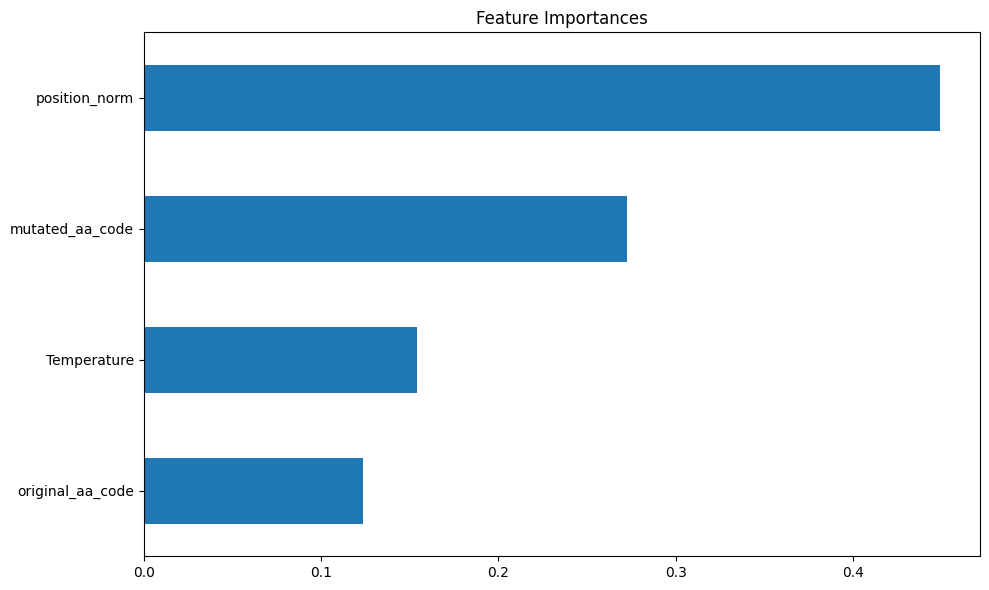

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

def load_data(filepath):
    try:
        df = pd.read_csv(filepath, delimiter=';', low_memory=False)
        print(f"Данные успешно загружены. Размер данных: {df.shape}")
        return df
    except FileNotFoundError:
        print(f"Файл {filepath} не найден.")
        return None

def preprocess_data(df): # предобработка
    df = df.copy()
    numeric_cols = ['Affinity_mut_parsed', 'Affinity_wt_parsed', 'Temperature',
                   'kon_mut_parsed', 'kon_wt_parsed', 'koff_mut_parsed', 'koff_wt_parsed']

    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    mask = (df['Affinity_mut_parsed'].notna() &
            df['Affinity_wt_parsed'].notna() &
            (df['Affinity_mut_parsed'] > 0) &
            (df['Affinity_wt_parsed'] > 0))

    df.loc[mask, 'DDG'] = (1.987e-3 * (df.loc[mask, 'Temperature'] + 273.15) *
                          np.log(df.loc[mask, 'Affinity_mut_parsed'] /
                                df.loc[mask, 'Affinity_wt_parsed']))

    df = df.dropna(subset=['DDG'])
    df['target'] = (df['DDG'] > 0).astype(int)

    # Извлекаем информацию о мутациях
    def extract_mutation_info(mutation_str):
        if pd.isna(mutation_str):
            return pd.Series([np.nan]*4)
        first_mut = mutation_str.split(',')[0].strip()
        import re
        match = re.match(r'([A-Za-z])([A-Z])(\d+)([A-Z])', first_mut)
        if match:
            return pd.Series(match.groups())
        return pd.Series([np.nan]*4)

    mutation_cols = ['chain', 'original_aa', 'position', 'mutated_aa']
    df[mutation_cols] = df['Mutation(s)_PDB'].apply(extract_mutation_info)
    df['position'] = pd.to_numeric(df['position'], errors='coerce')
    amino_acids = list('ACDEFGHIKLMNPQRSTVWY')
    aa_to_num = {aa: i for i, aa in enumerate(amino_acids)}

    df['original_aa_code'] = df['original_aa'].map(aa_to_num)
    df['mutated_aa_code'] = df['mutated_aa'].map(aa_to_num)
    df['original_aa_code'] = df['original_aa_code'].fillna(-1)
    df['mutated_aa_code'] = df['mutated_aa_code'].fillna(-1)
    df['position_norm'] = df['position'] / df['position'].max()
    features = [
        'original_aa_code', 'mutated_aa_code', 'position_norm',
        'Temperature'
    ]


    X = df[features].copy()
    y = df['target']
    for col in X.columns:
        if X[col].isnull().any():
            X[col].fillna(X[col].median(), inplace=True)

    return X, y, df

def train_model(X, y):
    # Разделение данных
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Масштабирование признаков
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Обучение модели
    model = RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        min_samples_split=5,
        class_weight='balanced',
        random_state=42
    )
    model.fit(X_train_scaled, y_train)

    # Оценка модели
    y_pred = model.predict(X_test_scaled)

    print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Важность признаков
    plt.figure(figsize=(10, 6))
    importances = pd.Series(model.feature_importances_, index=X.columns)
    importances.sort_values().plot(kind='barh')
    plt.title("Feature Importances")
    plt.tight_layout()
    plt.show()

    return model, scaler

def main():
    df = load_data('skempi_v2.csv')
    if df is None:
        return
    X, y, df_processed = preprocess_data(df)
    print(f"\nПосле предобработки: {X.shape[0]} samples")
    print(f"Class distribution:\n{y.value_counts(normalize=True)}")

    model, scaler = train_model(X, y)

if __name__ == "__main__":
    main()

## XGBClassifier

Данные успешно загружены. Размер данных: (7085, 29)


<ipython-input-11-dd4f56acf6ad>:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X[col].fillna(X[col].median(), inplace=True)



После предобработки: 4569 samples
Class distribution:
target
1    0.755526
0    0.244474
Name: proportion, dtype: float64
Accuracy: 0.782

Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.40      0.47       223
           1       0.82      0.91      0.86       691

    accuracy                           0.78       914
   macro avg       0.70      0.65      0.67       914
weighted avg       0.76      0.78      0.77       914



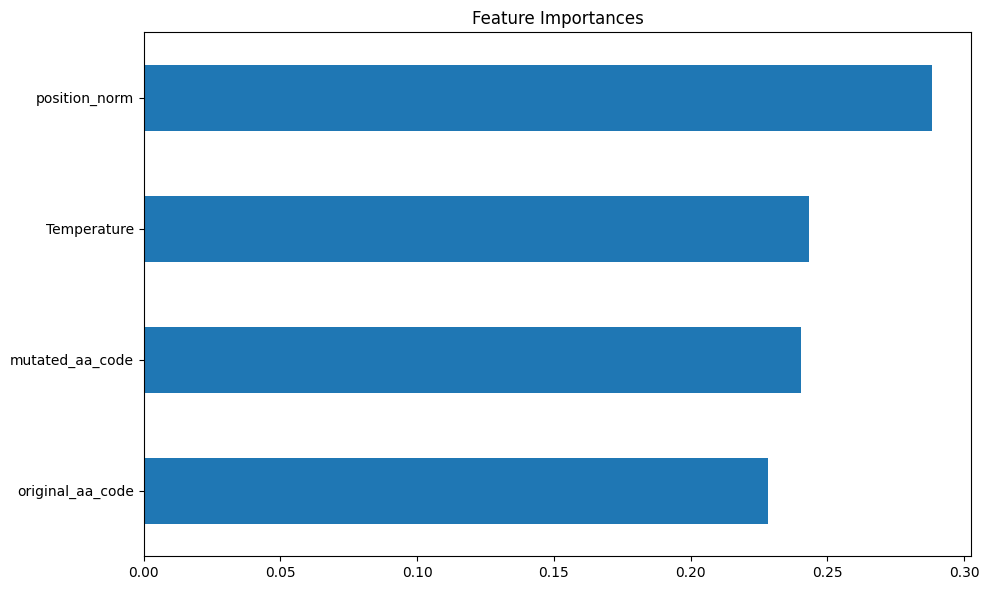

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
def load_data(filepath):
    try:
        df = pd.read_csv(filepath, delimiter=';', low_memory=False)
        print(f"Данные успешно загружены. Размер данных: {df.shape}")
        return df
    except FileNotFoundError:
        print(f"Файл {filepath} не найден.")
        return None

def preprocess_data(df):
    df = df.copy()

    numeric_cols = ['Affinity_mut_parsed', 'Affinity_wt_parsed', 'Temperature',
                   'kon_mut_parsed', 'kon_wt_parsed', 'koff_mut_parsed', 'koff_wt_parsed']
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    mask = (df['Affinity_mut_parsed'].notna() &
            df['Affinity_wt_parsed'].notna() &
            (df['Affinity_mut_parsed'] > 0) &
            (df['Affinity_wt_parsed'] > 0))

    df.loc[mask, 'DDG'] = (1.987e-3 * (df.loc[mask, 'Temperature'] + 273.15) *
                          np.log(df.loc[mask, 'Affinity_mut_parsed'] /
                                df.loc[mask, 'Affinity_wt_parsed']))

    df = df.dropna(subset=['DDG'])
    df['target'] = (df['DDG'] > 0).astype(int)
    def extract_mutation_info(mutation_str):
        if pd.isna(mutation_str):
            return pd.Series([np.nan]*4)
        first_mut = mutation_str.split(',')[0].strip()
        import re
        match = re.match(r'([A-Za-z])([A-Z])(\d+)([A-Z])', first_mut)
        if match:
            return pd.Series(match.groups())
        return pd.Series([np.nan]*4)

    mutation_cols = ['chain', 'original_aa', 'position', 'mutated_aa']
    df[mutation_cols] = df['Mutation(s)_PDB'].apply(extract_mutation_info)

    df['position'] = pd.to_numeric(df['position'], errors='coerce')
    amino_acids = list('ACDEFGHIKLMNPQRSTVWY')
    aa_to_num = {aa: i for i, aa in enumerate(amino_acids)}

    df['original_aa_code'] = df['original_aa'].map(aa_to_num)
    df['mutated_aa_code'] = df['mutated_aa'].map(aa_to_num)
    df['original_aa_code'] = df['original_aa_code'].fillna(-1)
    df['mutated_aa_code'] = df['mutated_aa_code'].fillna(-1)

    df['position_norm'] = df['position'] / df['position'].max()
    features = [
        'original_aa_code', 'mutated_aa_code', 'position_norm',
        'Temperature'
    ]


    X = df[features].copy()
    y = df['target']


    for col in X.columns:
        if X[col].isnull().any():
            X[col].fillna(X[col].median(), inplace=True)

    return X, y, df

def train_model(X, y):
    # Разделение данных
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Масштабирование признаков
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Обучение модели XGBClassifier

    model = XGBClassifier(
      n_estimators=500,
      max_depth=7,
      learning_rate=0.05,
      subsample=0.8,
      colsample_bytree=0.8,
      random_state=42)
    model.fit(X_train_scaled, y_train)

    # Оценка модели
    y_pred = model.predict(X_test_scaled)

    print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Важность признаков
    plt.figure(figsize=(10, 6))
    importances = pd.Series(model.feature_importances_, index=X.columns)
    importances.sort_values().plot(kind='barh')
    plt.title("Feature Importances")
    plt.tight_layout()
    plt.show()

    return model, scaler

def main():
    # Загрузка данных
    df = load_data('skempi_v2.csv')
    if df is None:
        return

    # Предобработка данных
    X, y, df_processed = preprocess_data(df)
    print(f"\nПосле предобработки: {X.shape[0]} samples")
    print(f"Class distribution:\n{y.value_counts(normalize=True)}")

    # Обучение модели
    model, scaler = train_model(X, y)

if __name__ == "__main__":
    main()

# Использование нейронных сетей

In [ ]:
import os
import requests
import pandas as pd
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

def setup_environment():
    !pip install biopandas tqdm requests
    os.makedirs('pdb_files', exist_ok=True)
    return 'pdb_files/'

def extract_pdb_ids(df):
    pdb_ids = set()
    for pdb_complex in df['#Pdb']:
        # Пример формата: '1A22_AB'
        pdb_id = pdb_complex.split('_')[0].lower()
        pdb_ids.add(pdb_id)
    return sorted(pdb_ids)

def download_pdb(pdb_id, pdb_dir, max_retries=3):
    url = f"https://files.rcsb.org/download/{pdb_id}.pdb"
    path = f"{pdb_dir}{pdb_id}.pdb"

    if os.path.exists(path):
        return True

    for _ in range(max_retries):
        try:
            response = requests.get(url, stream=True, timeout=10)
            if response.status_code == 200:
                with open(path, 'wb') as f:
                    f.write(response.content)
                return True
        except Exception as e:
            continue
    return False

def download_all_pdbs(df, pdb_dir, max_workers=10):
    pdb_ids = extract_pdb_ids(df)
    print(f"Найдено {len(pdb_ids)} уникальных PDB ID для загрузки")

    success = 0
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = []
        for pdb_id in pdb_ids:
            futures.append(executor.submit(download_pdb, pdb_id, pdb_dir))

        for future in tqdm(futures, total=len(pdb_ids), desc="Downloading PDBs"):
            success += future.result()

    print(f"\nУспешно загружено {success}/{len(pdb_ids)} PDB файлов")
    return success

def main():
    # Настройка окружения
    pdb_dir = setup_environment()

    # Загрузка данных SKEMPI 2.0
    !wget -q https://life.bsc.es/pid/skempi2/database/skempi_v2.csv
    df = pd.read_csv('skempi_v2.csv', delimiter=';')

    # Фильтрация и предобработка
    df = df[df['#Pdb'].notna()]
    df['#Pdb'] = df['#Pdb'].str.strip()

    # Загрузка PDB файлов
    download_all_pdbs(df, pdb_dir)

    # Проверка результатов
    downloaded_files = os.listdir(pdb_dir)
    print("\nПримеры загруженных файлов:", downloaded_files[:5])

if __name__ == "__main__":
    main()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.3/68.3 kB 665.2 kB/s eta 0:00:00
Найдено 345 уникальных PDB ID для загрузки



Успешно загружено 345/345 PDB файлов

Примеры загруженных файлов: ['1jtg.pdb', '4jfd.pdb', '1jck.pdb', '3btg.pdb', '1b41.pdb']


## эмбеддинги от предобученной модели ESM

In [ ]:
import torch
from transformers import AutoModelForMaskedLM, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
model = AutoModelForMaskedLM.from_pretrained("facebook/esm2_t6_8M_UR50D")

In [ ]:
!pip install Bio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.0/281.0 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 3.6 MB/s eta 0:00:00


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Данные успешно загружены. Размер данных: (7085, 29)


Создание признаков: 100%|██████████| 4550/4550 [00:00<00:00, 5207.76it/s]



Успешно обработано 786 мутаций из 4550 возможных
Использовано 164 уникальных белковых последовательностей

После предобработки: 786 samples
Class distribution:
1    0.723919
0    0.276081
Name: proportion, dtype: float64
Accuracy: 0.772

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.57      0.58        44
           1       0.84      0.85      0.84       114

    accuracy                           0.77       158
   macro avg       0.72      0.71      0.71       158
weighted avg       0.77      0.77      0.77       158



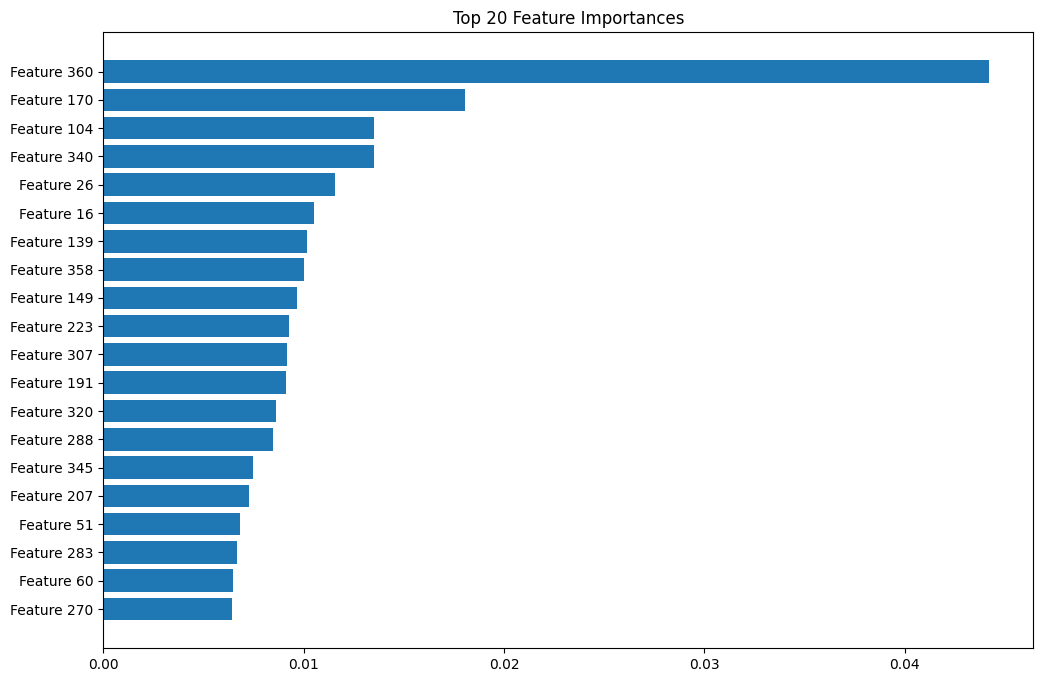

In [27]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt
import re
from Bio.PDB import PDBParser
from Bio.PDB.Polypeptide import PPBuilder
import os

# Загрузка предобученной модели ESM
def load_esm_model():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_name = "facebook/esm2_t6_8M_UR50D"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name).to(device)
    return tokenizer, model

# получение эмбеддингов последовательности
def get_esm_embeddings(sequence, tokenizer, model, device, max_length=1024):
    if not sequence:
        return np.zeros(320)

    inputs = tokenizer(sequence,
                      return_tensors="pt",
                      padding=True,
                      truncation=True,
                      max_length=max_length).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).cpu().numpy().flatten()

def load_data(filepath):
    try:
        df = pd.read_csv(filepath, delimiter=';', low_memory=False)
        return df
    except FileNotFoundError:
        print(f"Файл {filepath} не найден.")
        return None


def get_sequence_from_pdb(pdb_id, chain_id, pdb_dir='/content/pdb_files'):
    pdb_file = os.path.join(pdb_dir, f"{pdb_id}.pdb")
    if not os.path.exists(pdb_file):
        print(f"PDB файл {pdb_id} не найден")
        return None

    try:
        parser = PDBParser(QUIET=True)
        structure = parser.get_structure(pdb_id, pdb_file)
        ppb = PPBuilder()

        sequences = []
        for pp in ppb.build_peptides(structure):
            parent = pp[0].get_parent()
            if parent.id == chain_id:
                sequences.append(str(pp.get_sequence()))

        return ''.join(sequences) if sequences else None

def preprocess_data(df, tokenizer, model, device, pdb_dir='/content/pdb_files'):
    df = df.copy()
    numeric_cols = ['Affinity_mut_parsed', 'Affinity_wt_parsed', 'Temperature']
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    mask = (df['Affinity_mut_parsed'].notna() &
            df['Affinity_wt_parsed'].notna() &
            (df['Affinity_mut_parsed'] > 0) &
            (df['Affinity_wt_parsed'] > 0))

    df.loc[mask, 'DDG'] = (1.987e-3 * (df.loc[mask, 'Temperature'] + 273.15) *
                          np.log(df.loc[mask, 'Affinity_mut_parsed'] /
                                df.loc[mask, 'Affinity_wt_parsed']))

    df = df.dropna(subset=['DDG'])

    df['target'] = (df['DDG'] > 0).astype(int)
    def extract_mutation_info(mutation_str):
        if pd.isna(mutation_str):
            return None
        first_mut = mutation_str.split(',')[0].strip()
        match = re.match(r'([A-Za-z])([A-Z])(\d+)([A-Z])', first_mut)
        return match.groups() if match else None

    mutations = df['Mutation(s)_PDB'].apply(extract_mutation_info)
    df = df[mutations.notna()]
    mutations = mutations[mutations.notna()]

    # Добавляем информацию о PDB ID и цепи
    df['pdb_id'] = df['#Pdb'].str.split('_').str[0].str.lower()
    df['chain_id'] = [mut[0] for mut in mutations]

    # Получаем последовательности белков
    protein_sequences = {}
    unique_pdbs = df[['pdb_id', 'chain_id']].drop_duplicates()

    for _, row in tqdm(unique_pdbs.iterrows(), total=len(unique_pdbs), desc="Извлечение последовательностей"):
        seq = get_sequence_from_pdb(row['pdb_id'], row['chain_id'], pdb_dir)
        if seq:
            protein_sequences[(row['pdb_id'], row['chain_id'])] = seq

    if not protein_sequences:
        raise ValueError("Не удалось загрузить последовательности ни для одного белка. Проверьте наличие PDB файлов в папке pdb_files")

    # Генерируем эмбеддинги
    protein_embeddings = {}
    for (pdb_id, chain_id), seq in tqdm(protein_sequences.items(), desc="Генерация эмбеддингов"):
        protein_embeddings[(pdb_id, chain_id)] = get_esm_embeddings(seq, tokenizer, model, device)

    # Создаем фичи
    features = []
    valid_indices = []

    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Создание признаков"):
        key = (row['pdb_id'], row['chain_id'])
        if key not in protein_embeddings:
            continue

        orig_aa, position, mut_aa = mutations[idx][1], mutations[idx][2], mutations[idx][3]

        # One-hot кодирование
        aa_list = 'ACDEFGHIKLMNPQRSTVWY'
        orig_aa_onehot = [float(orig_aa == aa) for aa in aa_list]
        mut_aa_onehot = [float(mut_aa == aa) for aa in aa_list]

        # Собираем все фичи
        combined_features = np.concatenate([
            protein_embeddings[key],  # ESM эмбеддинг белка
            orig_aa_onehot,           # One-hot исходной аминокислоты
            mut_aa_onehot,            # One-hot мутированной аминокислоты
            [float(position)/1000],   # Нормализованная позиция
            [row['Temperature'] if pd.notna(row['Temperature']) else 25.0]
        ])

        features.append(combined_features)
        valid_indices.append(idx)

    X = np.array(features)
    y = df.loc[valid_indices, 'target'].values

    return X, y, df.loc[valid_indices]

def train_model(X, y):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    model = RandomForestClassifier(
        n_estimators=500,
        max_depth=10,
        min_samples_split=5,
        class_weight='balanced',
        n_jobs=-1,
        random_state=42
    )
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    importances = model.feature_importances_
    plt.figure(figsize=(12, 8))
    sorted_idx = np.argsort(importances)[-20:]  # Топ-20 важных признаков
    plt.barh(range(len(sorted_idx)), importances[sorted_idx])
    plt.yticks(range(len(sorted_idx)), [f"Feature {i}" for i in sorted_idx])
    plt.title("Top 20 Feature Importances")
    plt.show()

    return model

def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tokenizer, model = load_esm_model()
    df = load_data('skempi_v2.csv')
    if df is None:
        return
    X, y, df_processed = preprocess_data(df, tokenizer, model, device)
    print(f"\nПосле предобработки: {X.shape[0]} samples")
    print(f"Class distribution:\n{pd.Series(y).value_counts(normalize=True)}")
    model = train_model(X, y)

if __name__ == "__main__":
    main()

сеть

## Графовые нейросети

In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.7 MB/s eta 0:00:00


In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATConv, global_mean_pool
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
import re
from biopandas.pdb import PandasPdb

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_and_preprocess_data(csv_path, pdb_dir=None):
    df = pd.read_csv(csv_path, delimiter=';')

    numeric_cols = ['Affinity_mut_parsed', 'Affinity_wt_parsed', 'Temperature']
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    valid_rows = (df['Affinity_mut_parsed'].notna() &
                 df['Affinity_wt_parsed'].notna() &
                 (df['Affinity_mut_parsed'] > 0) &
                 (df['Affinity_wt_parsed'] > 0) &
                 df['Temperature'].notna())

    df = df[valid_rows].copy()

    # Вычисление ΔΔG
    df['ddG'] = (1.987e-3 * (df['Temperature'] + 273.15)) * np.log(df['Affinity_mut_parsed'] / df['Affinity_wt_parsed'])
    df['target'] = (df['ddG'] > 0).astype(int)

    # Извлечение информации о мутациях
    def parse_mutation(mut_str):
        if pd.isna(mut_str):
            return (None, None, None, None)
        first_mut = mut_str.split(',')[0].strip()
        match = re.match(r'([A-Za-z])([A-Z])(\d+)([A-Z])', first_mut)
        return match.groups() if match else (None, None, None, None)

    mutation_data = df['Mutation(s)_PDB'].apply(parse_mutation).tolist()
    df[['chain', 'orig_aa', 'position', 'mut_aa']] = pd.DataFrame(mutation_data, index=df.index)

    # Удаляем строки с некорректными мутациями
    df = df[df['chain'].notna() & df['orig_aa'].notna() &
            df['position'].notna() & df['mut_aa'].notna()]

    return df

# Создание графов из PDB файлов
class ProteinGraphDataset(Dataset):
    def __init__(self, df, pdb_dir, cutoff=8.0):
        super().__init__()
        self.df = df.reset_index(drop=True)
        self.pdb_dir = pdb_dir
        self.cutoff = cutoff

    def len(self):
        return len(self.df)

    def get(self, idx):
        row = self.df.iloc[idx]
        pdb_id = row['#Pdb'].split('_')[0].lower()
        chain = row['chain']

        try:
            pdb = PandasPdb().read_pdb(f'{self.pdb_dir}/{pdb_id}.pdb')
            atom_df = pdb.df['ATOM']
            chain_atoms = atom_df[atom_df['chain_id'] == chain]

            if chain_atoms.empty:
                return None

            residues = chain_atoms.groupby('residue_number')

            # Узлы: аминокислоты
            node_features = []
            residue_positions = []

            for resnum, res_atoms in residues:
                resname = res_atoms['residue_name'].iloc[0]
                if resname not in AA_TO_IDX:
                    continue

                aa_idx = AA_TO_IDX[resname]
                node_feat = [float(aa_idx == i) for i in range(len(AMINO_ACIDS))]
                node_feat.append(float(res_atoms['b_factor'].mean()))
                node_features.append(node_feat)

                ca_atom = res_atoms[res_atoms['atom_name'] == 'CA']
                if not ca_atom.empty:
                    residue_positions.append(ca_atom[['x_coord', 'y_coord', 'z_coord']].values[0])
                else:
                    residue_positions.append(res_atoms[['x_coord', 'y_coord', 'z_coord']].mean(axis=0))

            if not node_features:
                return None

            node_features = torch.tensor(node_features, dtype=torch.float)
            residue_positions = np.array(residue_positions)

            # Ребра
            dist_matrix = np.linalg.norm(
                residue_positions[:, None] - residue_positions[None, :], axis=-1)
            edge_index = torch.tensor(
                np.vstack(np.where(dist_matrix < self.cutoff)), dtype=torch.long)

            # Признаки мутации
            try:
                mut_pos = int(row['position']) - 1
                mut_feature = torch.zeros(len(node_features))
                if 0 <= mut_pos < len(mut_feature):
                    mut_feature[mut_pos] = 1.0
            except:
                return None

            return Data(
                x=node_features,
                edge_index=edge_index,
                mut_feature=mut_feature.unsqueeze(1),
                y=torch.tensor([row['target']], dtype=torch.float),
                pdb_id=pdb_id,
                mutation=row['Mutation(s)_PDB']
            )

        except Exception as e:
            print(f"Error processing {pdb_id}: {str(e)}")
            return None
# 3. Архитектура GNN модели
class GATModel(nn.Module):
    def __init__(self, num_features, hidden_dim=64, heads=4):
        super().__init__()
        self.conv1 = GATConv(num_features, hidden_dim, heads=heads)
        self.conv2 = GATConv(hidden_dim * heads, hidden_dim, heads=1)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim + 1, hidden_dim),  # +1 для мутационного признака
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, data):
        x, edge_index, mut_feature = data.x, data.edge_index, data.mut_feature

        # Графические слои
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))

        # Глобальное усреднение
        x = global_mean_pool(x, torch.zeros(x.size(0), dtype=torch.long, device=x.device))

        # Добавляем информацию о мутации
        x = torch.cat([x, mut_feature.mean(dim=0)], dim=-1)

        # Финальный классификатор
        return torch.sigmoid(self.mlp(x)).squeeze(-1)

# 4. Обучение модели
def train_model(train_loader, val_loader, num_features, epochs=50):
    model = GATModel(num_features).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.BCELoss()

    best_val_acc = 0
    train_losses = []
    val_accs = []

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for batch in tqdm(train_loader, desc=f'Epoch {epoch+1}'):
            batch = batch.to(DEVICE)
            optimizer.zero_grad()
            out = model(batch)
            loss = criterion(out, batch.y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        train_losses.append(epoch_loss / len(train_loader))

        # Валидация
        model.eval()
        y_true, y_pred = [], []

        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(DEVICE)
                out = model(batch)
                y_true.extend(batch.y.cpu().numpy())
                y_pred.extend(out.round().cpu().numpy())

        val_acc = accuracy_score(y_true, y_pred)
        val_accs.append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_gnn_model.pth')

        print(f'Epoch {epoch+1}: Loss = {train_losses[-1]:.4f}, Val Acc = {val_acc:.4f}')

    # Графики обучения
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.title('Training Loss')
    plt.subplot(1, 2, 2)
    plt.plot(val_accs, label='Validation Accuracy')
    plt.title('Validation Accuracy')
    plt.show()

    return model

def main():
    df = load_and_preprocess_data('skempi_v2.csv')
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
    train_dataset = ProteinGraphDataset(train_df, '/content/pdb_files')
    val_dataset = ProteinGraphDataset(val_df, '/content/pdb_files')
    train_dataset = [data for data in train_dataset if data is not None]
    val_dataset = [data for data in val_dataset if data is not None]
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32)

    # Обучение
    num_features = train_dataset[0].x.size(1)
    model = train_model(train_loader, val_loader, num_features)

    # Оценка
    evaluate_model(model, val_loader)

def evaluate_model(model, loader):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for batch in loader:
            batch = batch.to(DEVICE)
            out = model(batch)
            y_true.extend(batch.y.cpu().numpy())
            y_pred.extend(out.cpu().numpy())

    print("\nClassification Report:")
    print(classification_report(y_true, np.round(y_pred)))
    print(f"Accuracy: {accuracy_score(y_true, np.round(y_pred)):.4f}")

if __name__ == "__main__":
    main()

ValueError: num_samples should be a positive integer value, but got num_samples=0

# Идеи

* В итоге, самое простое решение показало адекватное качество - 0.76 accuracy,но есть куда стремиться и хочется попробовать более сложные методы, чтобы приблизиться к единице

Идеи :

1.   Учитывать расположение аминокислот в уже свернутом белке - тогда важность мутирования ак в активном центре намного больше периферических, это поможет модели верно делать предсказания, также можно добавить свойства аминокислот - потому что часто если аминокислота зменяется на другую с такими же свойствами, то это приносит меньший ущерб , чем если бы свойства кардинально изменились бы (например, полярная ак на гидрофобную)
2.   Стоит работать с графовым представлением белка, где отравжены аминокислоты их взаимодействия друг с другом. Это описывает структуру белка и взаимодействия между остатками - по этому можно понять, насколько критично изменение данной ак в контексте ее взаимодействий. Дальше стоит использовать либо с нуля графовые нейросети, либо использовать для задачи уже предобученные, которые есть и активно используются.Возможно, стоит поэкспериментировать со структурой графа - например, брать за вершины не аминокислоты, а их функциональные группы, возможно так граф будет более шумным, но это позволит более детально посмотреть на взаимодействия ак
3.   Стоит учитывать, что кроме того многие аминоксилоты могут не играть значительной роли в свернутом белке, однако быть важными при его фолдинге, выступая инициаторами
4.   Возможно, стоит учитывать эволюцию ак белка - используя выравнивание, можно понять насколько остаток вариабелен и важен соотвественно в данном белке.




